### Import libraries

In [1]:
#Import relevant libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #nicer rendering of plots in retina displays

from datetime import datetime
import calendar
import numpy as np
print ('Numpy version:', np.__version__)

import pandas as pd
print ('Pandas version:', pd.__version__)

import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly.graph_objs as go 
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)

import seaborn as sns
sns.set()
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

import re

Numpy version: 1.12.1
Pandas version: 0.20.3


### Load Data

In [2]:
# Load Data
uber = pd.read_csv('data/Uber Request Data.csv')
uber.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


#### Change format of datetime

In [3]:
# Request timestamp & Drop timestamp have different formats in data.
# we will use a consistent date-time format '%d-%b-%Y %H:%M:%S' 
#(so first convert all values(str) to default date-time('%Y-%m-%d %H:%M:%S') to '%d-%b-%Y %H:%M:%S' format)
uber['Request_timestamp'] = pd.to_datetime(pd.to_datetime(uber['Request timestamp']).dt.strftime('%d-%b-%Y %H:%M:%S'))
uber['Drop_timestamp'] = pd.to_datetime(pd.to_datetime(uber['Drop timestamp']).dt.strftime('%d-%b-%Y %H:%M:%S'))
uber.drop(labels = ['Request timestamp','Drop timestamp'],axis =1,inplace=True)
uber.head()

,Request id,Pickup point,Driver id,Status,Request_timestamp,Drop_timestamp
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


#### Rename column names(remove space)

In [4]:
uber.rename(columns={"Request id": "Request_id","Pickup point": "Pickup_point"},inplace=True)

#### Check for Null values

In [5]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request_id           6745 non-null int64
Pickup_point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request_timestamp    6745 non-null datetime64[ns]
Drop_timestamp       2831 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 316.2+ KB


#### 1. Status-Wise count

TypeError: 'AxesSubplot' object does not support indexing

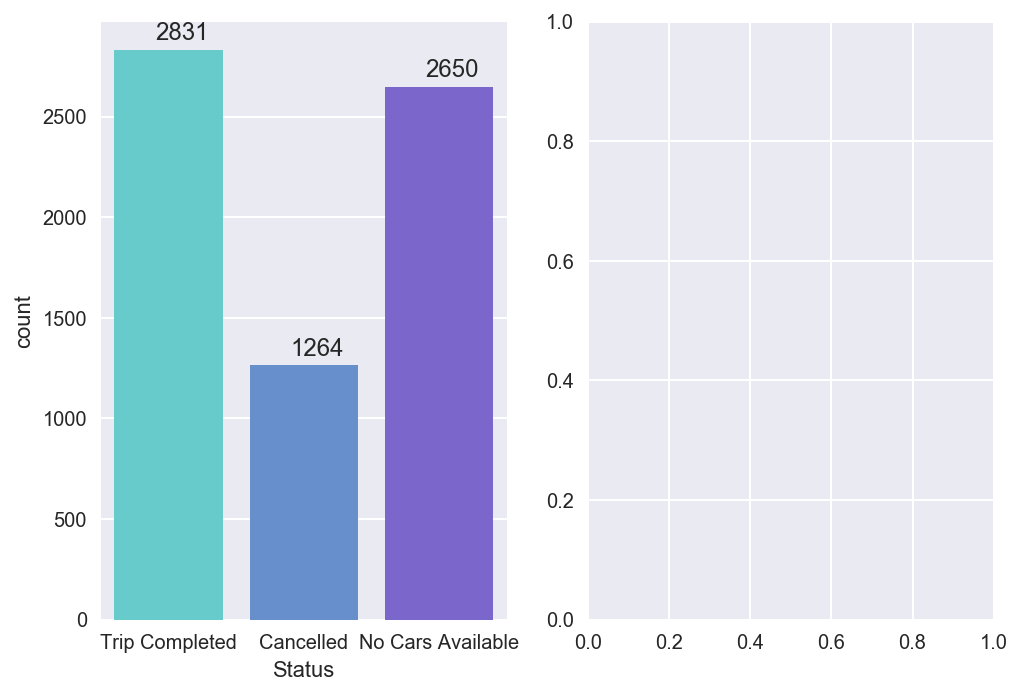

In [6]:
fig, ax =plt.subplots(1,2)
ax = sns.countplot(x= uber.Status,label=uber.Status,ax=ax[0])      
for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x()+0.3, p.get_height()+50))
        
ax = sns.countplot(x= uber.Status.apply(lambda x: 'Completed' if x=='Trip Completed' else 'Cancelled'),ax=ax[1])      
for p in ax.patches:
        ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(uber))), (p.get_x()+0.3, p.get_height()+20))        

fig.show()

#### *Insight: More than 50% trips are not completed either because of cancellation or 'No Cars Available'*

#### Define function for time slots(binning)

In [ ]:
#def time_slot(x):
#    
#    if x==0:
#        return 'Midnight'
#    elif x>=1 and x<3:
#        return 'Late Night'    
#    elif  (x>=3 and x<7):
#        return 'Early Morning'    
#    elif (x>=7 and x<12):
#        return 'Morning'
#    elif x>=12 and x<16:
#        return 'Afternoon'
#    elif x>=16 and x<20:
#        return 'Evening'
#    elif x>=20 and x<=23:
#        return 'Night'
#    else:
#        return 'Invalid'

#### Alternatively we can use pd.cut

In [ ]:
bins = [0, 1, 3, 7, 12, 16, 20, 23]
slot = ['Midnight', 'Late Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night']

#### Add new columns 'req_timeslot' & 'completed' in uber dataframe

In [ ]:
#uber['req_timeslot'] = uber['Request_timestamp'].apply(lambda x: time_slot(x.hour))  #User defined function
uber['req_timeslot'] = pd.cut(uber['Request_timestamp'].apply(lambda x: x.hour), bins, labels=slot) # pd.cut
uber['completed'] = uber['Status'].apply(lambda x: 1 if x =='Trip Completed' else 0)

#### Create new dataftame -> not_completed

In [ ]:
not_completed = uber[uber.completed==0]

#### 2. Count of  Not-completed trips(cancelled & no cars available) for different pick-up points.

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax = sns.countplot(x= not_completed.Pickup_point, hue= not_completed.Status )      
for p in ax.patches:
        ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(not_completed))), (p.get_x()+0.15, p.get_height()+20))

#### *Insight: Around 67.7% trips are not completed because of 'No Cars Available' & that mostly happens at Airport*

#### 3. Percentage of  'no cars available' at Airport for different timeslots.

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
x = not_completed[(not_completed['Status']=='No Cars Available') & (not_completed['Pickup_point']=='Airport')]
ax = sns.countplot(x= x['req_timeslot'])
for p in ax.patches:
        ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(x['req_timeslot']))), (p.get_x()+0.32, p.get_height()+10))

#### *Insight: Around 85 % of non-availability of cars at Airport is from evening till midnight*

#### 4. Percentage of  'no cars available' at Airport for evening and night timeslots.

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
x = not_completed[(not_completed['Status']=='No Cars Available') & (not_completed['Pickup_point']=='Airport') & ((not_completed['req_timeslot']=='Evening') | (not_completed['req_timeslot']=='Night'))]
ax = sns.countplot(x= x['Request_timestamp'].apply(lambda x: x.hour))
for p in ax.patches:
        ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(x['Request_timestamp']))), (p.get_x()+0.3, p.get_height()+5))

#### *Insight: More than 95 % of non-availability of cars at Airport is from 5PM to 10PM*

In [ ]:
ax = sns.countplot(x= uber.Status.apply(lambda x: 'Completed' if x=='Trip Completed' else 'Cancelled'))      
for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x()+0.3, p.get_height()+20))

In [ ]:
uber.head()






In [ ]:
x_data= uber['Request_timestamp'].apply(lambda x: calendar.day_name[x.weekday()])
y_data = uber.Status.apply(lambda x: 1 if x=='Trip Completed' else 0)
sns.swarmplot(x = x_data, y=y_data);